<a href="https://colab.research.google.com/github/AlonWolfi/kaggle--m5-forecasting-accuracy/blob/main/my_pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
if 'google.colab' in str(get_ipython()):
  import os, time
  SECONDS_TO_WAIT = 3

  print('Running on CoLab')
  if (os.path.exists('sample_data')):
    !rm -rf sample_data && rm -rf ./*
    !git clone https://github.com/AlonWolfi/kaggle--m5-forecasting-accuracy.git ./
  
  if not os.path.exists('data'):
    while(not os.path.exists('kaggle.json')):
      print('Waiting for kaggle.json')
      # !read -t SECONDS_TO_WAIT -n 1
      time.sleep(SECONDS_TO_WAIT)
    
    if os.path.exists('kaggle.json'):
        !mkdir /root/.kaggle
        !mv kaggle.json /root/.kaggle
        !kaggle competitions download -p data -c m5-forecasting-accuracy
else:
  print('Not running on CoLab')


Running on CoLab
Waiting for kaggle.json
Waiting for kaggle.json
Waiting for kaggle.json


In [ ]:
# base
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# matplotlib
%matplotlib inline

# display
from IPython.display import display

# autoreload
%load_ext autoreload
%autoreload 2

# warnings
import warnings
warnings.filterwarnings('ignore')

# fix random seed
from numpy.random import seed as set_random_seed
set_random_seed(42)

# explainability
import shap, lime, eli5
shap.initjs()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import math
import gc
# import dask.dataframe as dd
# import seaborn as sns
# import lightgbm as lgb
# from sklearn import preprocessing, metrics
# import gc
# import joblib
# import warnings

In [ ]:
X = pd.read_csv('data\X.csv', index_col=0)
y = pd.read_csv('data\y.csv', index_col=0)
X_submission = pd.read_csv('data\X_submission.csv', index_col=0)

level_indexs = None
weights_train, weights_test = None, None
RMSSE_denoms_dict = {}
sales_dict = {}
sales_test_dict = {}

C:\Alon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (13,14) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Alon\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (13,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
SUBMISSION = True
FULL_VALIDATION = False
SUBSAMPLE = False
SUBSAMPLE_DAY = 1750

TODOs:
- Evaluation:
    - try sales of test
    - try 2 last months
    - try feb last year (day.max()-365)
- Feature Engineering:
    - Categorical embedding
    - Time from last ...
    
Later:
- Training:
    - remove first zeros from train?
    - add weights to consider how much of that item is nonzero?
- Modeling:
    - ATIMA?
    - prediction loop
    - predict diff from trend?
- Optimazation:
    - GPU based LightGBM

In [ ]:
if not SUBMISSION and SUBSAMPLE:
    X = X[X['day'] > SUBSAMPLE_DAY]
    y = y.loc[X.index]
print('Starting day is {}'.format(X['day'].min()))

Starting day is 1400


In [ ]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
#         print(f'col {col} is of type {col_type}')
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def print_memory_usage():
    import sys

    local_vars = list(globals().items())
    for var, obj in local_vars:
        print(var, sys.getsizeof(obj))

In [ ]:
X = reduce_mem_usage(X)
y = reduce_mem_usage(y)
X_submission = reduce_mem_usage(X_submission)

C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 1629.10 Mb (35.1% reduction)
Mem. usage decreased to 149.46 Mb (37.5% reduction)
Mem. usage decreased to 177.49 Mb (35.1% reduction)


In [ ]:
X_all = pd.concat([X, X_submission])

if SUBMISSION:
    X_train = X
    y_train = y
    X_test = X_submission
    submission = X_submission[['day']]
#     del X_submission
else:
    test_mask = X['day'] > (X['day'].max() - 28)
    X_train = X[~test_mask]
    y_train = y[~test_mask]
    X_test = X[test_mask]
    y_test = y[test_mask]
    # For memory reduce
    del test_mask, X_submission
del X, y
gc.collect()

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')

C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


X_train.shape: (15671860, 20)
X_test.shape: (1707440, 20)


In [ ]:
y_train['sales'] = y_train['target'] * X_train['sell_price']

# if not SUBMISSION:
#     data_test = X_test.join(y_test)
#     data_test['sales'] = data_test['target'] * data_test['sell_price']

In [ ]:
_last_days_mask = X_train['day'] > (X_train['day'].max() - 28)
train_last_days = pd.concat([X_train[_last_days_mask], y_train[_last_days_mask]], axis = 1)
# For memory reduce
del _last_days_mask

In [ ]:
# Level 1 - X
# Level 2 - X.groupby(['state_id'])
# Level 3 - X.groupby(['store_id'])
# Level 4 - X.groupby(['cat_id'])
# Level 5 - X.groupby(['dept_id'])
# Level 6 - X.groupby(['state_id', 'cat_id'])
# Level 7 - X.groupby(['state_id', 'dept_id'])
# Level 8 - X.groupby(['store_id', 'dept_id'])
# Level 9 - X.groupby(['item_id'])
# Level 10 - X.groupby(['item_id', 'state_id'])
# Level 11 - X.groupby(['id'])
levels_groups = [
    [], # 1
    ['state_id'], # 2
    ['store_id'], # 3
    ['cat_id'], # 4
    ['dept_id'], # 5
    ['state_id', 'cat_id'], # 6
    ['state_id', 'dept_id'], # 7
    ['store_id', 'dept_id'], # 8
    ['item_id'], # 9
    ['item_id', 'state_id'], # 10
    ['id'], # 11
    
]
# len(X_test.groupby('id'))

def get_level_indexs(df, level):
    if level == []:
        return [df.index]
    else:
        level_indexs = []
        df.groupby(level).apply(lambda s: level_indexs.append(s.reset_index()['index']))
        return level_indexs

if not SUBMISSION and level_indexs is None:    
    level_indexs = [(get_level_indexs(X_train, level), get_level_indexs(X_test, level), get_level_indexs(train_last_days, level)) for level in levels_groups]

# Preprocess

## Feature Engineering

In [ ]:
# from sklearn import preprocessing
# from sklearn.compose import ColumnTransformer
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
X_train.head()

,id,item_id,dept_id,cat_id,store_id,state_id,day,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
HOBBIES_1_001_CA_1_1400,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1400,11443,Friday,7,11,2014,NaN,NaN,NaN,NaN,0,0,0,8.257812
HOBBIES_1_002_CA_1_1400,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1400,11443,Friday,7,11,2014,NaN,NaN,NaN,NaN,0,0,0,3.970703
HOBBIES_1_003_CA_1_1400,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1400,11443,Friday,7,11,2014,NaN,NaN,NaN,NaN,0,0,0,2.970703
HOBBIES_1_004_CA_1_1400,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1400,11443,Friday,7,11,2014,NaN,NaN,NaN,NaN,0,0,0,4.640625
HOBBIES_1_005_CA_1_1400,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1400,11443,Friday,7,11,2014,NaN,NaN,NaN,NaN,0,0,0,2.880859


In [ ]:
def dist_from_event(day_df, is_event_func):
    global dist_from_event_counter
    dist_from_event_counter = None
    def dist_from_event_helper(row):
        global dist_from_event_counter
        if is_event_func(row):
            dist_from_event_counter = 0
        elif dist_from_event_counter is not None:
            dist_from_event_counter += 1
        return dist_from_event_counter
    return day_df.apply(dist_from_event_helper, axis = 1)

def features_by_day(df):
    day_df = df[['day', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2']].drop_duplicates().set_index('day')
    extra_features = pd.DataFrame([], index = day_df.index)
        
    # Any event
    is_event_func = lambda row: type(row['event_name_1']) == str
    dist_from_event_counter = None
    extra_features['dist_from_any_event'] = dist_from_event(day_df, is_event_func).fillna(-1).astype('int')
    extra_features['dist_before_any_event'] = dist_from_event(day_df.iloc[::-1], is_event_func).fillna(-1).astype('int')
    extra_features['dist_any_event'] = np.minimum(extra_features['dist_from_any_event'], extra_features['dist_before_any_event'])
    
    # 2 Events
    is_event_func = lambda row: type(row['event_name_2']) == str
    dist_from_event_counter = None
    extra_features['dist_from_any_two_event'] = dist_from_event(day_df, is_event_func).fillna(-1).astype('int')
    extra_features['dist_before_any_two_event'] = dist_from_event(day_df.iloc[::-1], is_event_func).fillna(-1).astype('int')
    extra_features['dist_any_two_event'] = np.minimum(extra_features['dist_from_any_two_event'], extra_features['dist_before_any_two_event'])
    
    # Each type
    # added type(c) == str to check if not null
    event_types = [c for c in day_df['event_type_1'].unique() if type(c) == str]
    for event_type in event_types:
        is_event_func = lambda row: (row['event_type_1'] == event_type) or (row['event_type_2'] == event_type)
        dist_from_event_counter = None
        extra_features[f'dist_from_{event_type}_eventtype'] = dist_from_event(day_df, is_event_func).fillna(-1).astype('int')
        extra_features[f'dist_before_{event_type}_eventtype'] = dist_from_event(day_df.iloc[::-1], is_event_func).fillna(-1).astype('int')
        extra_features[f'dist_{event_type}_eventtype'] = np.minimum(extra_features[f'dist_from_{event_type}_eventtype'], extra_features[f'dist_before_{event_type}_eventtype'])
        
    # Each event
    # added type(c) == str to check if not null
    events = [c for c in day_df['event_name_1'].unique() if type(c) == str] + [c for c in day_df['event_name_2'].unique() if type(c) == str]
    for event in events:
        is_event_func = lambda row: (row['event_name_1'] == event) or (row['event_name_2'] == event)
        dist_from_event_counter = None
        extra_features[f'dist_from_{event}_event'] = dist_from_event(day_df, is_event_func).fillna(-1).astype('int')
        extra_features[f'dist_before_{event}_event'] = dist_from_event(day_df.iloc[::-1], is_event_func).fillna(-1).astype('int')
        extra_features[f'dist_{event}_event'] = np.minimum(extra_features[f'dist_from_{event}_event'], extra_features[f'dist_before_{event}_event'])
    
    return extra_features

def features_by_sell_price(df):
    df = df[['id', 'sell_price']]
    extra_features = pd.DataFrame([], index = df.index)
    df['sell_price_last_2dig'] = df['sell_price'] - np.floor(df['sell_price'])
    df['sell_price_last_dig'] = (10 * df['sell_price'] - np.floor(10 * df['sell_price'])) / 10
    
    extra_features['price_diff'] = df.groupby(['id'])['sell_price'].transform(lambda x: (x.shift(1) - x))
    extra_features['price_diff_precentage'] = extra_features['price_diff'] / df['sell_price']
    for lag in [7, 30, 60]:
        extra_features[f'price_max_{lag}'] = df.groupby(['id'])['sell_price'].transform(lambda x: (x.rolling(lag).max()))
        extra_features[f'price_max_diff_{lag}'] = extra_features[f'price_max_{lag}'] - df['sell_price']
        extra_features[f'price_max_diff_prec_{lag}'] = extra_features[f'price_max_diff_{lag}'] / df['sell_price']
        extra_features[f'price_min_{lag}'] = df.groupby(['id'])['sell_price'].transform(lambda x: (x.rolling(lag).min()))
        extra_features[f'price_min_diff_{lag}'] = extra_features[f'price_min_{lag}'] - df['sell_price']
        extra_features[f'price_min_diff_prec_{lag}'] = extra_features[f'price_min_diff_{lag}'] / df['sell_price']
        extra_features[f'price_mean_{lag}'] = df.groupby(['id'])['sell_price'].transform(lambda x: (x.rolling(lag).mean()))
        extra_features[f'price_mean_diff_{lag}'] = extra_features[f'price_mean_{lag}'] - df['sell_price']
        extra_features[f'price_mean_diff_prec_{lag}'] = extra_features[f'price_mean_diff_{lag}'] / df['sell_price']
        extra_features[f'price_std_{lag}'] = df.groupby(['id'])['sell_price'].transform(lambda x: (x.rolling(lag).std()))
    return extra_features
    

def encode_col(col_to_encode, df, is_onehot=False, na_value = 'None'):
    categories = df[col_to_encode].fillna(na_value).unique()
    if is_onehot:
        enc = OneHotEncoder()
        columns = [f'{col_to_encode}_{cat}' for cat in categories]
    else:
        enc = LabelEncoder()
        columns = [f'{col_to_encode}_enc']
    
    col_encoded = enc.fit_transform(categories.reshape((-1, 1)))

    if is_onehot:
        col_encoded = col_encoded.toarray()
        
    return pd.DataFrame(col_encoded, columns = columns, index = categories, dtype = 'int')


def non_target_features(X_train, X_test, X_all):
    cols_to_drop = []
    
    # day features
    day_features = features_by_day(X_all).pipe(reduce_mem_usage)
    X_train = X_train.join(day_features, on='day').pipe(reduce_mem_usage)
    X_test = X_test.join(day_features, on='day').pipe(reduce_mem_usage)
    
    # prices features
    sell_price_features = features_by_sell_price(X_all)
    X_train = pd.merge(X_train, sell_price_features, how='left', left_index=True, right_index=True).pipe(reduce_mem_usage)
    X_test = pd.merge(X_test, sell_price_features, how='left', left_index=True, right_index=True).pipe(reduce_mem_usage)
    
    # label encoding
    cols_to_label_encode = ['id', 'item_id']
    cols_to_drop += cols_to_label_encode
    for col in cols_to_label_encode:
        na_value = 'None'
        X_train[col] = X_train[col].fillna(na_value)
        X_test[col] = X_test[col].fillna(na_value)
        
        col_encoded = encode_col(col, X_all, is_onehot=False, na_value = na_value).pipe(reduce_mem_usage)
        
        X_train = X_train.join(col_encoded, on=col).pipe(reduce_mem_usage)
        X_test = X_test.join(col_encoded, on=col).pipe(reduce_mem_usage)
        
        X_train = X_train.drop(columns = [col])
        X_test = X_test.drop(columns = [col])
        
    
    # onehot encoding
    cols_to_onehot_encode = ['cat_id', 'dept_id', 'state_id', 'store_id', 'event_name_1', 'event_type_1', 'event_name_2', 'event_type_2', 'weekday']
    cols_to_drop += cols_to_onehot_encode
    for col in cols_to_onehot_encode:
        na_value = 'None'
        X_train[col] = X_train[col].fillna(na_value)
        X_test[col] = X_test[col].fillna(na_value)
        
        col_encoded = encode_col(col, X_all, is_onehot=True, na_value = na_value).pipe(reduce_mem_usage)
        
        X_train = X_train.join(col_encoded, on=col).pipe(reduce_mem_usage)
        X_test = X_test.join(col_encoded, on=col).pipe(reduce_mem_usage)
        
        X_train = X_train.drop(columns = [col])
        X_test = X_test.drop(columns = [col])
#     # drop columns
#     X_train = X_train.drop(columns = cols_to_drop)
#     X_test = X_test.drop(columns = cols_to_drop)
    return X_train, X_test

def target_features(X, y):
    data = pd.concat([X[['id']], y], axis = 1, sort=False)
    extra_features = pd.DataFrame([], index = data.index)
    for lag in [3, 7, 30]:
        for col in ['target', 'sales']:
            extra_features[f'{col}_mean_{lag}'] = data.groupby(['id'])[col].transform(lambda x: x.shift(1).rolling(lag).mean())
            extra_features[f'{col}_std_{lag}'] = data.groupby(['id'])[col].transform(lambda x: x.shift(1).rolling(lag).std())
    return extra_features.pipe(reduce_mem_usage)


In [ ]:
FE_target_train = target_features(X_train, y_train)
X_train, X_test = non_target_features(X_train, X_test, X_all)
X_train = pd.merge(X_train, FE_target_train, how='left', left_index=True, right_index=True).pipe(reduce_mem_usage)
del FE_target_train

Mem. usage decreased to 478.27 Mb (60.0% reduction)
Mem. usage decreased to  0.11 Mb (53.9% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 4543.54 Mb (0.0% reduction)
Mem. usage decreased to 392.43 Mb (20.7% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Mem. usage decreased to 6140.07 Mb (0.0% reduction)
Mem. usage decreased to 576.64 Mb (0.0% reduction)


C:\Alon\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:251: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mem. usage decreased to  0.29 Mb (16.7% reduction)
Mem. usage decreased to 6169.96 Mb (0.0% reduction)
Mem. usage decreased to 579.90 Mb (0.0% reduction)
Mem. usage decreased to  0.03 Mb (16.7% reduction)
Mem. usage decreased to 6080.29 Mb (0.0% reduction)
Mem. usage decreased to 570.13 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (45.0% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 6005.56 Mb (0.0% reduction)
Mem. usage decreased to 561.99 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (58.3% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 5990.61 Mb (0.0% reduction)
Mem. usage decreased to 560.36 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (45.0% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 5915.89 Mb (0.0% reduction)
Mem. usage decreased to 552.22 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (62.5% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 5945.78 Mb (0.0% reduction)
Mem. usage decreased to 555.48 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (70.5% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 6289.53 Mb (0.0% reduction)
Mem. usage decreased to 592.93 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (53.6% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 6244.69 Mb (0.0% reduction)
Mem. usage decreased to 588.04 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (37.5% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in less
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in less


Mem. usage decreased to 6155.02 Mb (0.0% reduction)
Mem. usage decreased to 578.27 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (37.5% reduction)
Mem. usage decreased to 6065.34 Mb (0.0% reduction)
Mem. usage decreased to 568.50 Mb (0.0% reduction)
Mem. usage decreased to  0.00 Mb (58.3% reduction)
Mem. usage decreased to 6050.40 Mb (0.0% reduction)
Mem. usage decreased to 566.87 Mb (0.0% reduction)
Mem. usage decreased to 6289.53 Mb (0.0% reduction)


In [ ]:
X_train = X_train.fillna(-1.)
X_test = X_test.fillna(-1.)

In [ ]:
try:
    X_train = reduce_mem_usage(X_train)
    X_test = reduce_mem_usage(X_test)
except:
    print('Not a DataFrame!')

Mem. usage decreased to 6289.53 Mb (0.0% reduction)
Mem. usage decreased to 553.85 Mb (0.0% reduction)


In [ ]:
# del X_all
max_train_day = X_train['day'].max()
X_all = X_all[X_all['day'] > (max_train_day - 31)]
gc.collect()

20

In [ ]:
# for memory issues
# del train_new, test_new
# del X_test_num, X_train_cat, X_test_cat, X_train_num, data_test, data_train, X_test, X_train, test_mask, y, X

# Modeling

## Weighting

In [ ]:
def get_id_from_index(y_index):
    return pd.DataFrame(pd.Series(y_index, name='id').apply(lambda s: s.rsplit('_',1)[0])).set_index(y_index)

def group_y_by_id(y):
    return y.groupby(get_id_from_index(y.index)['id'])

def get_weight_for_id(s):
    return (np.diff(s) ** 2).mean()

def get_weights_per_id(y):
    weights_per_id = group_y_by_id(y)['target'].apply(get_weight_for_id).rename('weight')
    return weights_per_id

def get_weights(y_train, test_index):
    weights_per_id = get_weights_per_id(y_train)
    weights_train = 1. / (get_id_from_index(y_train.index).join(pd.DataFrame(weights_per_id), on='id')['weight'] + 1e-1)
    weights_test = 1. / (get_id_from_index(test_index).join(pd.DataFrame(weights_per_id), on='id')['weight'] + 1e-1)
    return weights_train, weights_test

if (weights_train is None or weights_test is None) and not SUBMISSION:
    weights_train, weights_test = get_weights(y_train, X_test.index)

In [ ]:
weights_train

## Training

In [ ]:
lgb_params = {
        "objective" : "poisson",
        "metric" :"rmse",
        "force_row_wise" : True,
        "learning_rate" : 0.075,
#         "sub_feature" : 0.3,
        "sub_row" : 0.75,
        "bagging_freq" : 1,
        "lambda_l2" : 0.1,
#         "nthread" : 4
        "metric": ["rmse"],
    'verbosity': 2,
    'copy_X': False,
    'num_iterations' : 1200
}

In [ ]:
pd.Series(model.feature_importances_, index = X_train.columns).sort_values().to_dict()

NameError: name 'model' is not defined

In [ ]:
def get_correlation_with_target(X, y, col):
    corr = X[col].corr(y['target'])
    if np.isnan(corr):
        corr = 0.
    return corr

corr_dict = {}
for col in X_train.columns:
    if col not in corr_dict:
        corr_dict[col] = get_correlation_with_target(X_train, y_train, col)
        print(f'{col}: {corr_dict[col]}')
       

day: 0.0187754708244299
wm_yr_wk: 0.021740903275778975
wday: -0.03534409964859863
month: -0.005614591571998576
year: 0.018944743589656074
snap_CA: 0.011243498722318774
snap_TX: 0.014279547819677002
snap_WI: 0.013993462842643195
sell_price: -0.13312226822954584
dist_from_any_event: 0.012727140345313323
dist_before_any_event: 0.0029121739133203587
dist_any_event: 0.010578136629142781
dist_from_any_two_event: 0.0
dist_before_any_two_event: -0.0187754708244299
dist_any_two_event: 0.0
dist_from_Religious_eventtype: 0.004382251506934898
dist_before_Religious_eventtype: 0.003308735827219709
dist_Religious_eventtype: 0.002719351131118698
dist_from_National_eventtype: 0.0077808106735519555
dist_before_National_eventtype: 0.0045348774780794784
dist_National_eventtype: 0.009616398321800765
dist_from_Sporting_eventtype: 0.002091823943063173
dist_before_Sporting_eventtype: 0.008141215475377587
dist_Sporting_eventtype: 0.008069102802049291
dist_from_Cultural_eventtype: 0.01009450028493027
dist_befor

event_name_1_LentWeek2: 0.003065932736996521
event_name_1_Purim End: -0.0024983063812682267
event_name_1_StPatricksDay: -0.0031010676752135026
event_name_1_Easter: -0.0010841578805169953
event_name_1_Pesach End: -0.00017758479488115707
event_name_1_OrthodoxEaster: -9.06283147943021e-05
event_name_1_Cinco De Mayo: -0.0026756444270473376
event_name_1_Mother's day: -0.0013594580805688142
event_name_1_MemorialDay: -0.005028112291378913
event_name_1_NBAFinalsStart: 0.007512611115620909
event_name_1_NBAFinalsEnd: -0.003292645210154422
event_name_1_Ramadan starts: 0.0036448261114725433
event_name_1_Father's day: 0.002865892008159292
event_name_1_IndependenceDay: 0.0019634563894923734
event_name_1_Eid al-Fitr: -0.0027976643393345484
event_name_1_LaborDay: -0.0015623565341047496
event_name_1_EidAlAdha: -0.0029135355180845
event_name_1_ColumbusDay: 0.003113210554692852
event_name_1_Halloween: -0.005968968017940217
event_name_1_VeteransDay: 0.0038855887611716077
event_name_1_Thanksgiving: -0.0020

In [ ]:
pd.Series(corr_dict)[np.abs(pd.Series(corr_dict)) <= 0.01].index.tolist()

['month',
 'dist_before_any_event',
 'dist_from_any_two_event',
 'dist_any_two_event',
 'dist_from_Religious_eventtype',
 'dist_before_Religious_eventtype',
 'dist_Religious_eventtype',
 'dist_from_National_eventtype',
 'dist_before_National_eventtype',
 'dist_National_eventtype',
 'dist_from_Sporting_eventtype',
 'dist_before_Sporting_eventtype',
 'dist_Sporting_eventtype',
 'dist_before_Cultural_eventtype',
 'dist_Cultural_eventtype',
 'dist_from_Chanukah End_event',
 'dist_Chanukah End_event',
 'dist_from_Christmas_event',
 'dist_Christmas_event',
 'dist_from_NewYear_event',
 'dist_before_NewYear_event',
 'dist_NewYear_event',
 'dist_from_OrthodoxChristmas_event',
 'dist_before_OrthodoxChristmas_event',
 'dist_OrthodoxChristmas_event',
 'dist_from_MartinLutherKingDay_event',
 'dist_before_MartinLutherKingDay_event',
 'dist_MartinLutherKingDay_event',
 'dist_from_SuperBowl_event',
 'dist_before_SuperBowl_event',
 'dist_SuperBowl_event',
 'dist_from_ValentinesDay_event',
 'dist_before

In [ ]:
cols_correlated = pd.Series(corr_dict)[np.abs(pd.Series(corr_dict)) > 0.01].index.tolist()
X_train = X_train[cols_correlated]

In [ ]:
submission = reduce_mem_usage(submission)
del X_submission

Mem. usage decreased to 96.28 Mb (0.0% reduction)


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
del train_last_days

In [ ]:
print_memory_usage()

__name__ 57
__doc__ 113
__package__ 16
__loader__ 16
__spec__ 16
__builtin__ 80
__builtins__ 80
_ih 344
_oh 240
_dh 72
In 344
Out 240
get_ipython 64
exit 56
quit 56
_ 28
__ 28
___ 28
_i 269
_ii 61
_iii 107
_i1 358
pd 80
np 80
plt 80
mean_squared_error 136
math 80
gc 80
_i2 321
level_indexs 16
weights_train 16
weights_test 16
RMSSE_denoms_dict 240
sales_dict 240
sales_test_dict 240
_i3 129
SUBMISSION 28
FULL_VALIDATION 24
SUBSAMPLE 24
SUBSAMPLE_DAY 28
_i4 191
_i5 1796
reduce_mem_usage 136
print_memory_usage 136
_i6 142
_i7 543
X_all 1822104304
X_train 7719416464
y_train 1343770784
X_test 703250024
submission 223459384
_i8 242
_i9 243
train_last_days 543703344
_i10 1217
levels_groups 152
get_level_indexs 136
_i11 328
OneHotEncoder 1184
LabelEncoder 1056
_i12 63
_12 3179
_i13 8270
dist_from_event 136
features_by_day 136
features_by_sell_price 136
encode_col 136
non_target_features 136
target_features 136
_i14 297
dist_from_event_counter 28
_i15 106
_i16 169
_i17 161
max_train_day 26
_17 2

In [ ]:
gc.collect()

2815

In [ ]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
model = LGBMRegressor(**lgb_params)
# model = LinearRegression()
model.fit(X_train, y_train['target'])

LGBMRegressor(bagging_freq=1, boosting_type='gbdt', class_weight=None,
              colsample_bytree=1.0, copy_X=False, force_row_wise=True,
              importance_type='split', lambda_l2=0.1, learning_rate=0.075,
              max_depth=-1, metric=['rmse'], min_child_samples=20,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=100,
              n_jobs=-1, num_iterations=1200, num_leaves=31,
              objective='poisson', random_state=None, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, sub_row=0.75, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0, verbosity=2)

In [ ]:
def target_features_test(X, y):
    data = pd.concat([X[['item_id','id', 'day']], y], axis = 1, sort=False)
    last_day = data['day'].max()
    print(last_day)
    data_last_day = data[data['day'] == last_day]
    cols_to_drop = data_last_day.columns
    data = data[data['day'] < last_day]
#     extra_features_for_last_day = pd.DataFrame([], index = data_last_day.index)
    for lag in [3, 7, 30]:
        data_sub = data[data['day'] >= (last_day-lag)]
        data_sub['target'] = data_sub['target'].astype('float')
        data_sub['sales'] = data_sub['sales'].astype('float')
        data_sub_grouped_by = data_sub.groupby('id')
        for col in ['target', 'sales']:
#             display(data_sub[data_sub['item_id'] == 'HOBBIES_1_003'][['day', 'target']])
#             display(data_sub[data_sub['item_id'] == 'HOBBIES_1_003'].groupby('id')[col].describe())
#             display(data_sub[data_sub['item_id'] == 'HOBBIES_1_003'].groupby('id')[col].mean())
#             display(data_sub[data_sub['item_id'] == 'HOBBIES_1_003'].groupby('id')[col].mean().values)
#             display(data_last_day.join(vv, on = 'id')[data_last_day['item_id'] == 'HOBBIES_1_003'])
#             display(vv[vv.index.str.startswith('HOBBIES_1_003')])
#             display(vv[vv.index.str.startswith('HOBBIES_1_003')].values)
#             data_groupby_id = data_sub.groupby('id')[col]
            data_last_day = data_last_day.join(data_sub.groupby('id')[col].mean().rename(f'{col}_mean_{lag}'), on = 'id')
            data_last_day = data_last_day.join(data_sub.groupby('id')[col].std().rename(f'{col}_std_{lag}'), on = 'id')
#             display(extra_features_for_last_day[extra_features_for_last_day.index.str.startswith('HOBBIES_1_003_CA_1')][f'{col}_mean_{lag}'])
#             raise RuntimeError('asdf')
    return data_last_day.drop(columns=cols_to_drop).pipe(reduce_mem_usage)

In [ ]:
#predict_recursive(model, X_test, X_all, y_train)
days_to_predict = X_test['day'].unique().tolist()
y_pred = []
y_all = pd.DataFrame({'target':None, 'sales':None}, index = X_all.index)

# X_test_full = pd.DataFrame([])

for col in y_train.columns:
    y_all[col].update(y_train[col])

for i, day in enumerate(days_to_predict):
    print(f'predicting day {day}')
    X_all_day = X_all[X_all['day'] <= day]
    y_all_day = y_all.loc[X_all_day.index]
    X_test_day = X_test[X_test['day'] == day]
    
    FE_target_test = target_features_test(X_all_day, y_all_day)
    X_test_day = pd.merge(X_test_day, FE_target_test, how='left', left_index=True, right_index=True).pipe(reduce_mem_usage)
    X_test_day = X_test_day.fillna(-1.)
#     X_test_full = pd.concat([X_test_full, X_test_day])
    
    y_pred_day = model.predict(X_test_day[cols_correlated])
    y_pred = np.concatenate((y_pred, y_pred_day))

    y_all['target'].loc[X_test_day.index] = y_pred_day
    y_all['sales'].loc[X_test_day.index] = y_pred_day * X_test_day['sell_price']
    y_all = reduce_mem_usage(y_all)
    gc.collect()

predicting day 1914
1914


C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Alon\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.23 Mb (1.7% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1915
1915
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.23 Mb (1.7% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1916
1916
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.23 Mb (1.7% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1917
1917
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.23 Mb (1.7% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1918
1918
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.23 Mb (1.7% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1919
1919
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.23 Mb (1.7% reduction)
Mem. usage dec

Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1961
1961
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.15 Mb (2.5% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1962
1962
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.15 Mb (2.5% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1963
1963
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.18 Mb (2.2% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1964
1964
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.18 Mb (2.2% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1965
1965
Mem. usage decreased to  0.93 Mb (69.2% reduction)
Mem. usage decreased to 10.18 Mb (2.2% reduction)
Mem. usage decreased to 140.71 Mb (0.0% reduction)
predicting day 1966
1966
Mem. usage decreased to  0.93 Mb (69.2%

In [ ]:
X_train

,day,wm_yr_wk,wday,year,snap_CA,snap_TX,snap_WI,sell_price,dist_from_any_event,dist_any_event,...,sales_mean_3,sales_std_3,target_mean_7,target_std_7,sales_mean_7,sales_std_7,target_mean_30,target_std_30,sales_mean_30,sales_std_30
HOBBIES_1_001_CA_1_1400,1400,11443,7,2014,0,0,0,8.257812,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
HOBBIES_1_002_CA_1_1400,1400,11443,7,2014,0,0,0,3.970703,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
HOBBIES_1_003_CA_1_1400,1400,11443,7,2014,0,0,0,2.970703,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
HOBBIES_1_004_CA_1_1400,1400,11443,7,2014,0,0,0,4.640625,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
HOBBIES_1_005_CA_1_1400,1400,11443,7,2014,0,0,0,2.880859,-1,-1,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_1913,1913,11613,2,2016,0,0,0,2.980469,28,6,...,0.993652,1.720703,0.142822,0.377930,0.425781,1.126953,0.166626,0.530762,0.496826,1.582031
FOODS_3_824_WI_3_1913,1913,11613,2,2016,0,0,0,2.480469,28,6,...,0.826660,1.431641,0.142822,0.377930,0.354248,0.937500,0.300049,0.535156,0.744141,1.327148
FOODS_3_825_WI_3_1913,1913,11613,2,2016,0,0,0,3.980469,28,6,...,1.327148,2.298828,0.571289,0.786621,2.275391,3.130859,0.933105,1.142578,3.714844,4.546875
FOODS_3_826_WI_3_1913,1913,11613,2,2016,0,0,0,1.280273,28,6,...,1.707031,1.956055,0.856934,1.069336,1.097656,1.369141,1.000000,1.114258,1.280273,1.426758


In [ ]:
def get_full_by_id(id_to_show):
    temp = X_train[(X_all.loc[X_train.index].id == id_to_show)]
#     temp = pd.concat([temp,y_train.loc[temp.index]], axis=1)
    temp = pd.concat([temp, X_test_full])
    temp = temp[(X_all.loc[temp.index].id == id_to_show)]
    temp = pd.concat([temp, y_all.loc[temp.index]], axis=1)
    temp = temp[[c for c in temp.columns if ('target' in c) or ('sales' in c) or ('day' == c)]]
    return temp
# temp = get_full_by_id(np.random.choice(X_all.id.unique().tolist()))

In [ ]:
for i in range(10):
    id_to_show = np.random.choice(X_all.id.unique().tolist())
#     display(X_test[(X_all.loc[X_test.index].id == id_to_show)])
    plt.plot(X_all[X_all.id == id_to_show]['day'], y_all[X_all.id == id_to_show]['target'])
    plt.title(id_to_show)
    plt.show()

In [ ]:
# y_pred = model.predict(X_test)
# y_pred = y_all['target'].loc[X_test.index]

In [ ]:
y_all['target'].loc[X_test.index]

In [ ]:
y_pred

In [ ]:
# y_pred[y_pred < 0] = 0

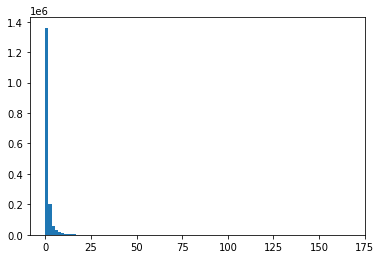

In [ ]:
plt.hist(y_pred, bins=100)
plt.show()

# Test - Score Calculation

In [ ]:
y_pred = pd.Series(data=y_pred, index = X_test.index, name='pred')

In [ ]:
%%time
def calculate_RMSSE_denom(data_train):
    train_sales = data_train.groupby('day')['target'].sum()
    nonzeros = train_sales.to_numpy().nonzero()[0]
    if nonzeros.size == 0:
        return 0
    first_nonzero = nonzeros[0]
#     print(f'first_nonzero: {first_nonzero} from {len(train_sales)}')
    train_sales = train_sales[first_nonzero:]
    if train_sales.size == 1:
        return 0
    return (np.mean(np.diff(train_sales).astype('int32') ** 2))

def calculate_RMSSE_num(y_pred, y_test, test_day):
    test_sub = pd.concat([test_day, y_test, y_pred], axis=1)
    test_groupedbyday = test_sub.groupby('day')[['target', 'pred']].sum()
    num = np.mean((test_groupedbyday['target'] - test_groupedbyday['pred']).to_numpy().astype('int32')**2)
    return num

def calculate_RMSSE(data_train_sub, y_pred_sub, y_test_sub, test_day_sub, level, level_c):
    EPS = 1e-3
    if (level, level_c) not in RMSSE_denoms_dict:
        RMSSE_denoms_dict[(level, level_c)] = calculate_RMSSE_denom(data_train_sub)
    denom = RMSSE_denoms_dict[(level, level_c)]
    num = calculate_RMSSE_num(y_pred_sub, y_test_sub, test_day_sub)
#     print(f'denom: {denom}, num: {num}')
    return np.sqrt(num / (denom+EPS))

def calculate_sales(train_last_days, level, level_c):
    if (level, level_c) not in sales_dict:
        sales_dict[(level, level_c)] = train_last_days['sales'].sum()
    return sales_dict[(level, level_c)]

def calculate_test_sales(test_sub, level, level_c):
    if (level, level_c) not in sales_test_dict:
        sales_test_dict[(level, level_c)] = test_sub['sales'].sum()
    return sales_test_dict[(level, level_c)]

def test_score(y_pred, y_test, data_train, data_test, train_last_days):
    scores = []
    scores_by_test = []
    for level, level_groupby in enumerate(levels_groups):
        print(f'started level {level}')
        rmsses = []
        weights = []
        weights_by_test = []
        # level_indexs
        for level_count, (train_index, test_index, last_days_index) in enumerate(zip(*level_indexs[level])):
            data_train_sub = data_train.loc[train_index]
            y_pred_sub = y_pred.loc[test_index]
            y_test_sub = y_test.loc[test_index]
            test_day_sub = data_test[['day']].loc[test_index]
            test_sub = data_test.loc[test_index]
            train_last_days_sub = train_last_days.loc[last_days_index]

            rmsse = calculate_RMSSE(data_train_sub, y_pred_sub, y_test_sub, test_day_sub, level, level_count)
            sales = calculate_sales(train_last_days_sub, level, level_count)
            sales_by_test = calculate_test_sales(test_sub, level, level_count)
            
            rmsses.append(rmsse)
            weights.append(sales)
            weights_by_test.append(sales_by_test)
            
            if np.isnan(rmsse) or np.isnan(sales):
                print(level_count)
                print(f'rmsse of {rmsse} with sales of {sales}')

        weights = np.array(weights) / np.sum(weights)
        weights_by_test = np.array(weights_by_test) / np.sum(weights_by_test)
        
        level_score = np.sum(rmsses * weights)
        level_score_by_test = np.sum(rmsses * weights_by_test)
        scores.append(level_score)
        scores_by_test.append(level_score_by_test)
        
        print(f'finished level ({level}) : {level_groupby} with {level_count + 1} subs and score: {level_score}, {level_score_by_test}')
    return np.sum(scores) / len(levels_groups), np.sum(scores_by_test) / len(levels_groups)
if not SUBMISSION and FULL_VALIDATION:
    total_score, total_score_2 = test_score(y_pred, y_test, data_train, data_test, train_last_days)


Wall time: 0 ns


In [ ]:
if FULL_VALIDATION:
    print(total_score, total_score_2)

In [ ]:
from sklearn.metrics import mean_squared_error
if not SUBMISSION:
    approx_total_score = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred, sample_weight=weights_test))

In [ ]:
approx_total_score

0.7797048625788798

In [ ]:
if FULL_VALIDATION:
    print(np.mean([
        total_score,
        approx_total_score
    ]))

# Submission

In [ ]:
if not SUBMISSION:
    raise Exception('Not Submission')

sample_submission = pd.read_csv('raw_data\sample_submission.csv')

# y_submission_demo = pd.Series(data=1, index = submission.index)
y_submission = pd.Series(data=y_pred, index = submission.index, name='target')

public_Fday_to_days = {f'F{str(c)}': f'd_{c + 1913}'for c in range(1, 30)}
private_Fday_to_days = {f'F{str(c)}': f'd_{c + 1941}'for c in range(1, 30)}

y_submission_public = y_submission[submission['day'] <= 1941]
y_submission_private = y_submission[submission['day'] > 1941]


def process_y_submission(y_submission):
    y_submission = pd.DataFrame(y_submission, columns = ['target'])
    index_splitted = pd.Series(y_submission.index, index=y_submission.index).apply(lambda s: s.rsplit('_', 1))
    y_submission['new_index'] = index_splitted.apply(lambda l: l[0])
    y_submission['day'] = index_splitted.apply(lambda l: l[1])
    return y_submission

def parse_ss(s):
    ss = s.copy()
    day = ss['day'][0]
    ss = ss.set_index('new_index')
    ss = ss.drop('day', axis = 1)
    return ss, day

def process_submission(y_submission, index_suffix, Fday_to_days):
    y_submission = process_y_submission(y_submission)
    submission_df = pd.DataFrame(index=y_submission['new_index'].copy().unique())
    def add_to_submission(s):
        ss, day = parse_ss(s)
        submission_df[f'd_{day}'] = ss['target']
    y_submission.groupby('day').apply(add_to_submission)
    submission_df = submission_df.set_index(submission_df.index + index_suffix)
    submission_df = submission_df.rename(columns = {v:k for k,v in Fday_to_days.items()})
    return submission_df

submission_public = process_submission(y_submission_public, '_validation', public_Fday_to_days)
submission_private = process_submission(y_submission_private, '_evaluation', private_Fday_to_days)

submission = pd.concat([submission_public, submission_private])
submission = submission.reset_index().rename(columns = {'index': 'id'})

assert((submission['id'] == sample_submission['id']).all())

submission.to_csv('submissions\submission.csv', index = False)

In [ ]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.968046,0.909913,0.911527,0.931961,1.018386,1.344831,1.391060,1.138544,1.095283,...,0.985463,1.298417,1.382825,0.990398,0.833564,0.847996,0.862081,0.947629,1.210013,1.136255
1,HOBBIES_1_002_CA_1_validation,0.170569,0.181117,0.181538,0.206299,0.224344,0.255519,0.251166,0.254782,0.275216,...,0.326849,0.402430,0.470723,0.262986,0.239635,0.241004,0.265527,0.304747,0.362017,0.389455
2,HOBBIES_1_003_CA_1_validation,0.563826,0.526419,0.514957,0.556411,0.606844,0.823884,0.890029,0.661785,0.655085,...,0.901747,1.171961,1.156758,0.741063,0.673869,0.656189,0.648458,0.721630,0.988364,1.036836
3,HOBBIES_1_004_CA_1_validation,1.952273,1.551540,1.626042,1.794334,2.066231,2.574819,2.668943,1.985142,1.928893,...,2.053039,2.674549,2.786058,2.031487,1.870461,1.751729,1.685500,1.895271,2.581272,2.669208
4,HOBBIES_1_005_CA_1_validation,1.205711,1.148355,1.174090,1.317876,1.426478,1.627885,1.571603,1.214223,1.165168,...,1.294760,1.690321,1.715600,1.217097,1.090454,1.102105,1.130723,1.241539,1.678028,1.706395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0.442257,0.427771,0.402234,0.414018,0.653678,0.626045,0.601911,0.475923,0.471374,...,0.573113,0.760220,0.807705,0.564627,0.564635,0.585620,0.511359,0.618888,0.724686,0.646248
60976,FOODS_3_824_WI_3_evaluation,0.505941,0.473921,0.476757,0.488585,0.608217,0.715070,0.881530,0.589274,0.548531,...,0.850482,1.192673,0.949019,0.691198,0.681946,0.700328,0.612662,0.734253,0.882752,0.804614
60977,FOODS_3_825_WI_3_evaluation,0.730039,0.675904,0.693637,0.711254,0.796392,1.003710,0.989164,0.787574,0.722290,...,0.791490,1.080514,1.090883,0.746532,0.740730,0.767615,0.663444,0.794022,0.962257,0.865695
60978,FOODS_3_826_WI_3_evaluation,1.187662,1.117062,1.038041,1.066537,1.254507,1.541164,1.475622,1.203556,1.124061,...,1.336163,2.237410,1.824454,1.270772,1.283911,1.320087,1.195229,1.409915,1.754132,1.458500


In [ ]:
sample_submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60975,FOODS_3_823_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60976,FOODS_3_824_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60977,FOODS_3_825_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
60978,FOODS_3_826_WI_3_evaluation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
